In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [147]:
def simulate(S1_zero, S2_zero, sigma1, sigma2, r, T, N):
    dt = T/N  # Time step
    Z1 = np.random.randn(N-1)  # Brownian increments for asset 1
    Z2 = np.random.randn(N-1)  # Brownian increments for asset 2
    dW1 = np.sqrt(dt)*Z1  # Scaled Brownian increments for asset 1
    dW2 = np.sqrt(dt)*Z2  # Scaled Brownian increments for asset 2
    
    # Initialize price arrays
    S1 = np.zeros(N)
    S2 = np.zeros(N)
    S1[0] = S1_zero  # Initial price for asset 1
    S2[0] = S2_zero  # Initial price for asset 2

    # Simulate asset price paths using geometric Brownian motion
    for i in range(1, N):
        S1[i] = S1[i-1] + S1[i-1]*(r*dt + sigma1 * dW1[i-1])
        S2[i] = S2[i-1] + S2[i-1]*(r*dt + sigma2 * dW2[i-1])

    return (S1, S2)

def F(t, x1, x2, sigma1, sigma2, T):
    # Analytical pricing formula for the spread option (Margrabe formula structure)
    num1 = np.log(x1/x2) + (sigma1**2 + sigma2**2)*(T - t)/2
    num2 = np.log(x1/x2) - (sigma1**2 + sigma2**2)*(T - t)/2
    den = np.sqrt((sigma1**2 + sigma2**2)*(T - t))
    
    return x1 * norm.cdf(num1/den) - x2 * norm.cdf(num2/den)

def hedge(T, N, S1, S2, r, sigma1, sigma2):
    # Initialize hedging portfolio components
    H0 = np.zeros(N)  # Risk-free asset (discounted cash)
    H1 = np.zeros(N)  # Quantity of asset S1
    H2 = np.zeros(N)  # Quantity of asset S2
    eps = 1e-4  # Small perturbation for numerical derivative

    for i in range(N):
        t = i * T / N
        # Compute delta with respect to S1 using central difference
        H1[i] = (
            F(t, np.exp(-r*t)*S1[i] + eps, np.exp(-r*t)*S2[i], sigma1, sigma2, T) -
            F(t, np.exp(-r*t)*S1[i] - eps, np.exp(-r*t)*S2[i], sigma1, sigma2, T)
        ) / (2 * eps)

        # Compute delta with respect to S2 using central difference
        H2[i] = (
            F(t, np.exp(-r*t)*S1[i], np.exp(-r*t)*S2[i] + eps, sigma1, sigma2, T) -
            F(t, np.exp(-r*t)*S1[i], np.exp(-r*t)*S2[i] - eps, sigma1, sigma2, T)
        ) / (2 * eps)

        # Compute the remaining amount needed in the risk-free asset to match the option price
        H0[i] = (
            F(t, np.exp(-r*t)*S1[i], np.exp(-r*t)*S2[i], sigma1, sigma2, T)
            - H1[i] * np.exp(-r*t)*S1[i]
            - H2[i] * np.exp(-r*t)*S2[i]
        )

    return (H0, H1, H2)
        

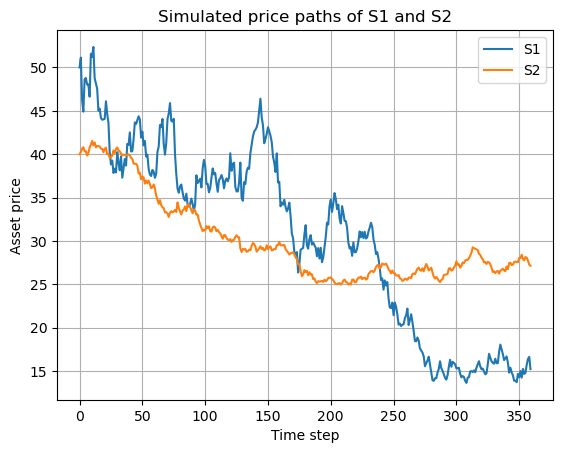

In [148]:
# Parameters
S1_zero = 50     # Initial price of asset S1
S2_zero = 40     # Initial price of asset S2
sigma1 = 0.7     # Volatility of asset S1
sigma2 = 0.2     # Volatility of asset S2
r = 0.05         # Risk-free interest rate
T = 1            # Time horizon (in years)
N = int(360 * T) # Number of time steps (daily frequency)

# Simulate asset price paths
S1, S2 = simulate(S1_zero, S2_zero, sigma1, sigma2, r, T, N)

# Plot the simulated trajectories of S1 and S2

plt.plot(S1, label='S1')  # Plot asset S1
plt.plot(S2, label='S2')  # Plot asset S2
plt.title("Simulated price paths of S1 and S2")
plt.xlabel("Time step")
plt.ylabel("Asset price")
plt.legend()
plt.grid(True)
plt.show()

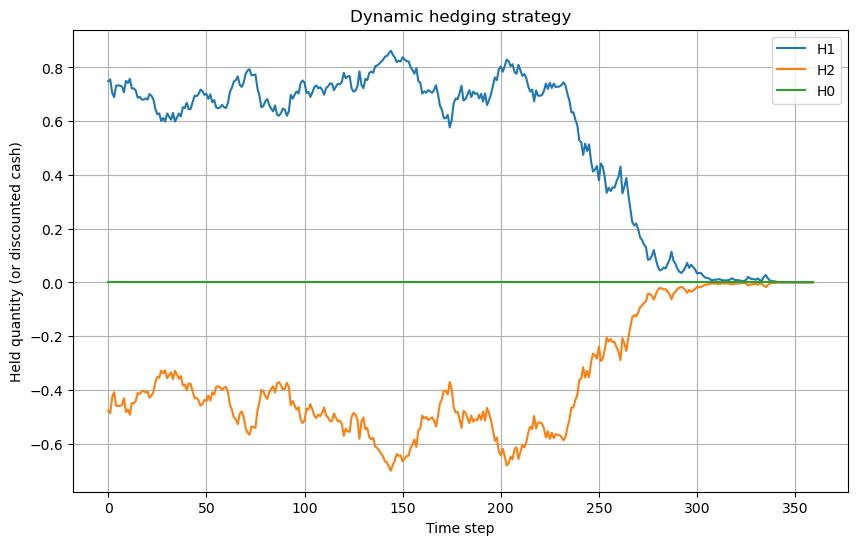

In [149]:
# Compute the dynamic hedging strategy
H0, H1, H2 = hedge(T, N, S1, S2, r, sigma1, sigma2)

# Plot the hedging strategy components over time
plt.figure(figsize=(10, 6))
plt.plot(H1, label='H1')  # Quantity of asset S1 in the portfolio
plt.plot(H2, label='H2')  # Quantity of asset S2 in the portfolio
plt.plot(H0, label='H0')  # Position in the risk-free asset (discounted)
plt.title("Dynamic hedging strategy")
plt.xlabel("Time step")
plt.ylabel("Held quantity (or discounted cash)")
plt.legend()
plt.grid(True)
plt.show()

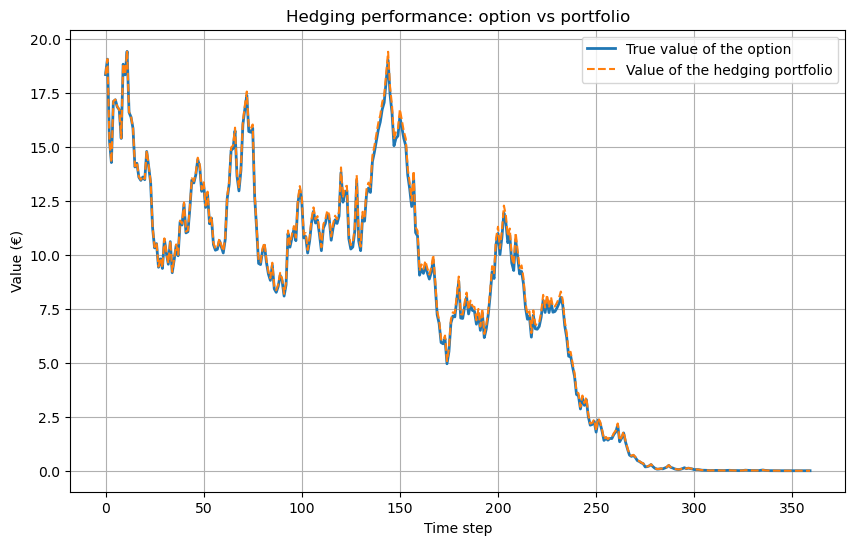

In [150]:
# Initialize arrays to store the option value and the replicating portfolio value
option_value = np.zeros(N)
portfolio_value = np.zeros(N)

# Compute the value of the option and the portfolio at each time step
for i in range(N):
    t = i * T / N  # Current time
    # Discounted prices of the assets
    Stilde1 = np.exp(-r * t) * S1[i]
    Stilde2 = np.exp(-r * t) * S2[i]
    
    # Compute the theoretical value of the option
    option_value[i] = F(t, Stilde1, Stilde2, sigma1, sigma2, T)
    
    # Compute the value of the replicating portfolio
    portfolio_value[i] = H0[i] * np.exp(r * t) + H1[i] * S1[i] + H2[i] * S2[i]

# Plot the comparison between the option and portfolio values
plt.figure(figsize=(10, 6))
plt.plot(option_value, label="True value of the option", linewidth=2)  # Theoretical option value
plt.plot(portfolio_value, label="Value of the hedging portfolio", linestyle='--')  # Replicating portfolio
plt.title("Hedging performance: option vs portfolio")
plt.xlabel("Time step")
plt.ylabel("Value (€)")
plt.legend()
plt.grid(True)
plt.show()

In [151]:
print(F(0, S1_zero, S2_zero, sigma1, sigma2, T))

18.353759286437583
